# A Data Analysis of United States Housing Data

Primary Inquiry: Is it possible to utilize linear regression to predict a Market Estimate Price for a home given its Area (square footage), number of bedrooms, bathrooms, etc.? 

Additional Inquiries: Is there a general trend in housing prices across the United States? Is the average number of square feet, bedrooms, or bathrooms different across different regions of the U.S.? Can one classify homes into three categories: affordable, family, and luxury based off the given data>?

Kaggle Dataset Link: https://www.kaggle.com/datasets/febinphilips/us-house-listings-2023?resource=download

Data Set Utilized: Original_Extracted_df (not the cleaned one!)

## Step 1: Data Cleaning

To begin with the process of data cleaning, we first must read in the datafile. Additionally, below are all the packages and modules used in this project:

In [12]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Reading in data file
df = pd.read_csv("C:/Users/claro/INFO 1998 Intro to Machine Learning/Housing Prices Project/original_extracted_df.csv") #input your directory
df.head(5)

,State,City,Street,Zipcode,Latitude,Longitude,Bedroom,Bathroom,Area,PPSq,LotArea,ConvertedLot,LotUnit,MarketEstimate,RentEstimate,Price
0,AL,Saraland,Scott Dr,36571.0,30.819534,-88.095960,4.0,2.0,1614.0,148.636927,0.38050,0.38050,acres,240600.0,1599.0,239900.0
1,AL,Southside,Big Oak Dr W,35907.0,33.881050,-86.012436,3.0,2.0,1474.0,0.000678,0.67034,0.67034,acres,186700.0,1381.0,1.0
2,AL,Robertsdale,Cowpen Creek Rd,36567.0,30.590004,-87.580376,3.0,2.0,1800.0,144.388889,3.20000,3.20000,acres,NaN,NaN,259900.0
3,AL,Gulf Shores,Spinnaker Dr #201,36542.0,30.284956,-87.747920,2.0,2.0,1250.0,274.000000,NaN,NaN,NaN,NaN,NaN,342500.0
4,AL,Chelsea,Mallet Way,35043.0,33.357986,-86.608700,3.0,3.0,2224.0,150.629496,0.26000,0.26000,acres,336200.0,1932.0,335000.0


### Removing Rows Without Addresses
After entering the datafile, we can begin cleaning. I decide to drop all of the rows where the address is missing, since rows with a missing address will be of little help in the data analysis soon to come. 

In [13]:
## Filtering out rows with missing adresses (386 rows filtered out)
# initializing list to contain indices of rows w/ nan values for address
nan_indices = []

# looping to identify indices where adress = nan
for i in range(len(df)):
    if type(df.iloc[i,1]) == float and math.isnan(df.iloc[i,1]) == True:
        nan_indices.append(i)
        
# removing indices in nan_indices
# resetting index 
df = df.drop(index = nan_indices)
df = df.reset_index(drop = True) # drop=true, removes previous index column

### Filling in NaN Values
Next, we must replace the missing data values, marked currently as NaN with a numerical value. I chose to implement a smart average, where I took the average of all the values in the column with based on state. For example, all of the NaN values in the 'Area' column for houses in Alabama will be replaced with the average area of houses in Alabama. This process is repeated for all the features that will be utilized in this data analysis: MarketEstimate, Area, Bedroom, and |Bathroom.

In [14]:
## replacing nan values with smart averages (avgs by state)
# taking means
avg_MarketEstimate = df.groupby("State")["MarketEstimate"].mean()
avg_Area = df.groupby("State")["Area"].mean()
avg_Bedroom = df.groupby("State")["Bedroom"].mean()
avg_Bathroom = df.groupby("State")["Bathroom"].mean()

for i in range(len(df)):
    # reset state key 
    state = ''
    # replacing nan values for Market_Estimate column
    if math.isnan(df.iloc[i,13]) == True:
        state = df.iloc[i,0]
        df.iloc[i,13] = avg_MarketEstimate[state] #set nan to its repspective state avg
    # replacing nan values for Area column
    state = ''
    if math.isnan(df.iloc[i,8]) == True:
        state = df.iloc[i,0]
        df.iloc[i,8] = avg_Area[state] #set nan to its repspective state avg
    # replacing nan values for Bedroom column
    state = ''
    if math.isnan(df.iloc[i,6]) == True:
        state = df.iloc[i,0]
        df.iloc[i,6] = avg_Bedroom[state] #set nan to its repspective state avg
    # replaceing nan values for Bathroom column
    state = ''
    if math.isnan(df.iloc[i,7]) == True:
        state = df.iloc[i,0]
        df.iloc[i,7] = avg_Bathroom[state] #set nan to its repspective state avg

### Adding Region Feature & Preparing Data for Future Visualizations
Now that all of the relavent columns contain only real numbers, we can proceed to the next step of the data cleaning process. Since Region is a feature that will be used to answer one of our inquiries, we must create that feature as it is not provided in the original dataset. Thus, the code below adds a column 'Feature' to our dataframe df. Additionally, I am initializing a few lists to house MarketEstimate (ME) and Area data by region; these lists will be used for our future violin plots. The reason I am appending values to these lists now is to reduce the number of times the dataframe is iterated through. 

Also, for a visual, I am using the following classification system: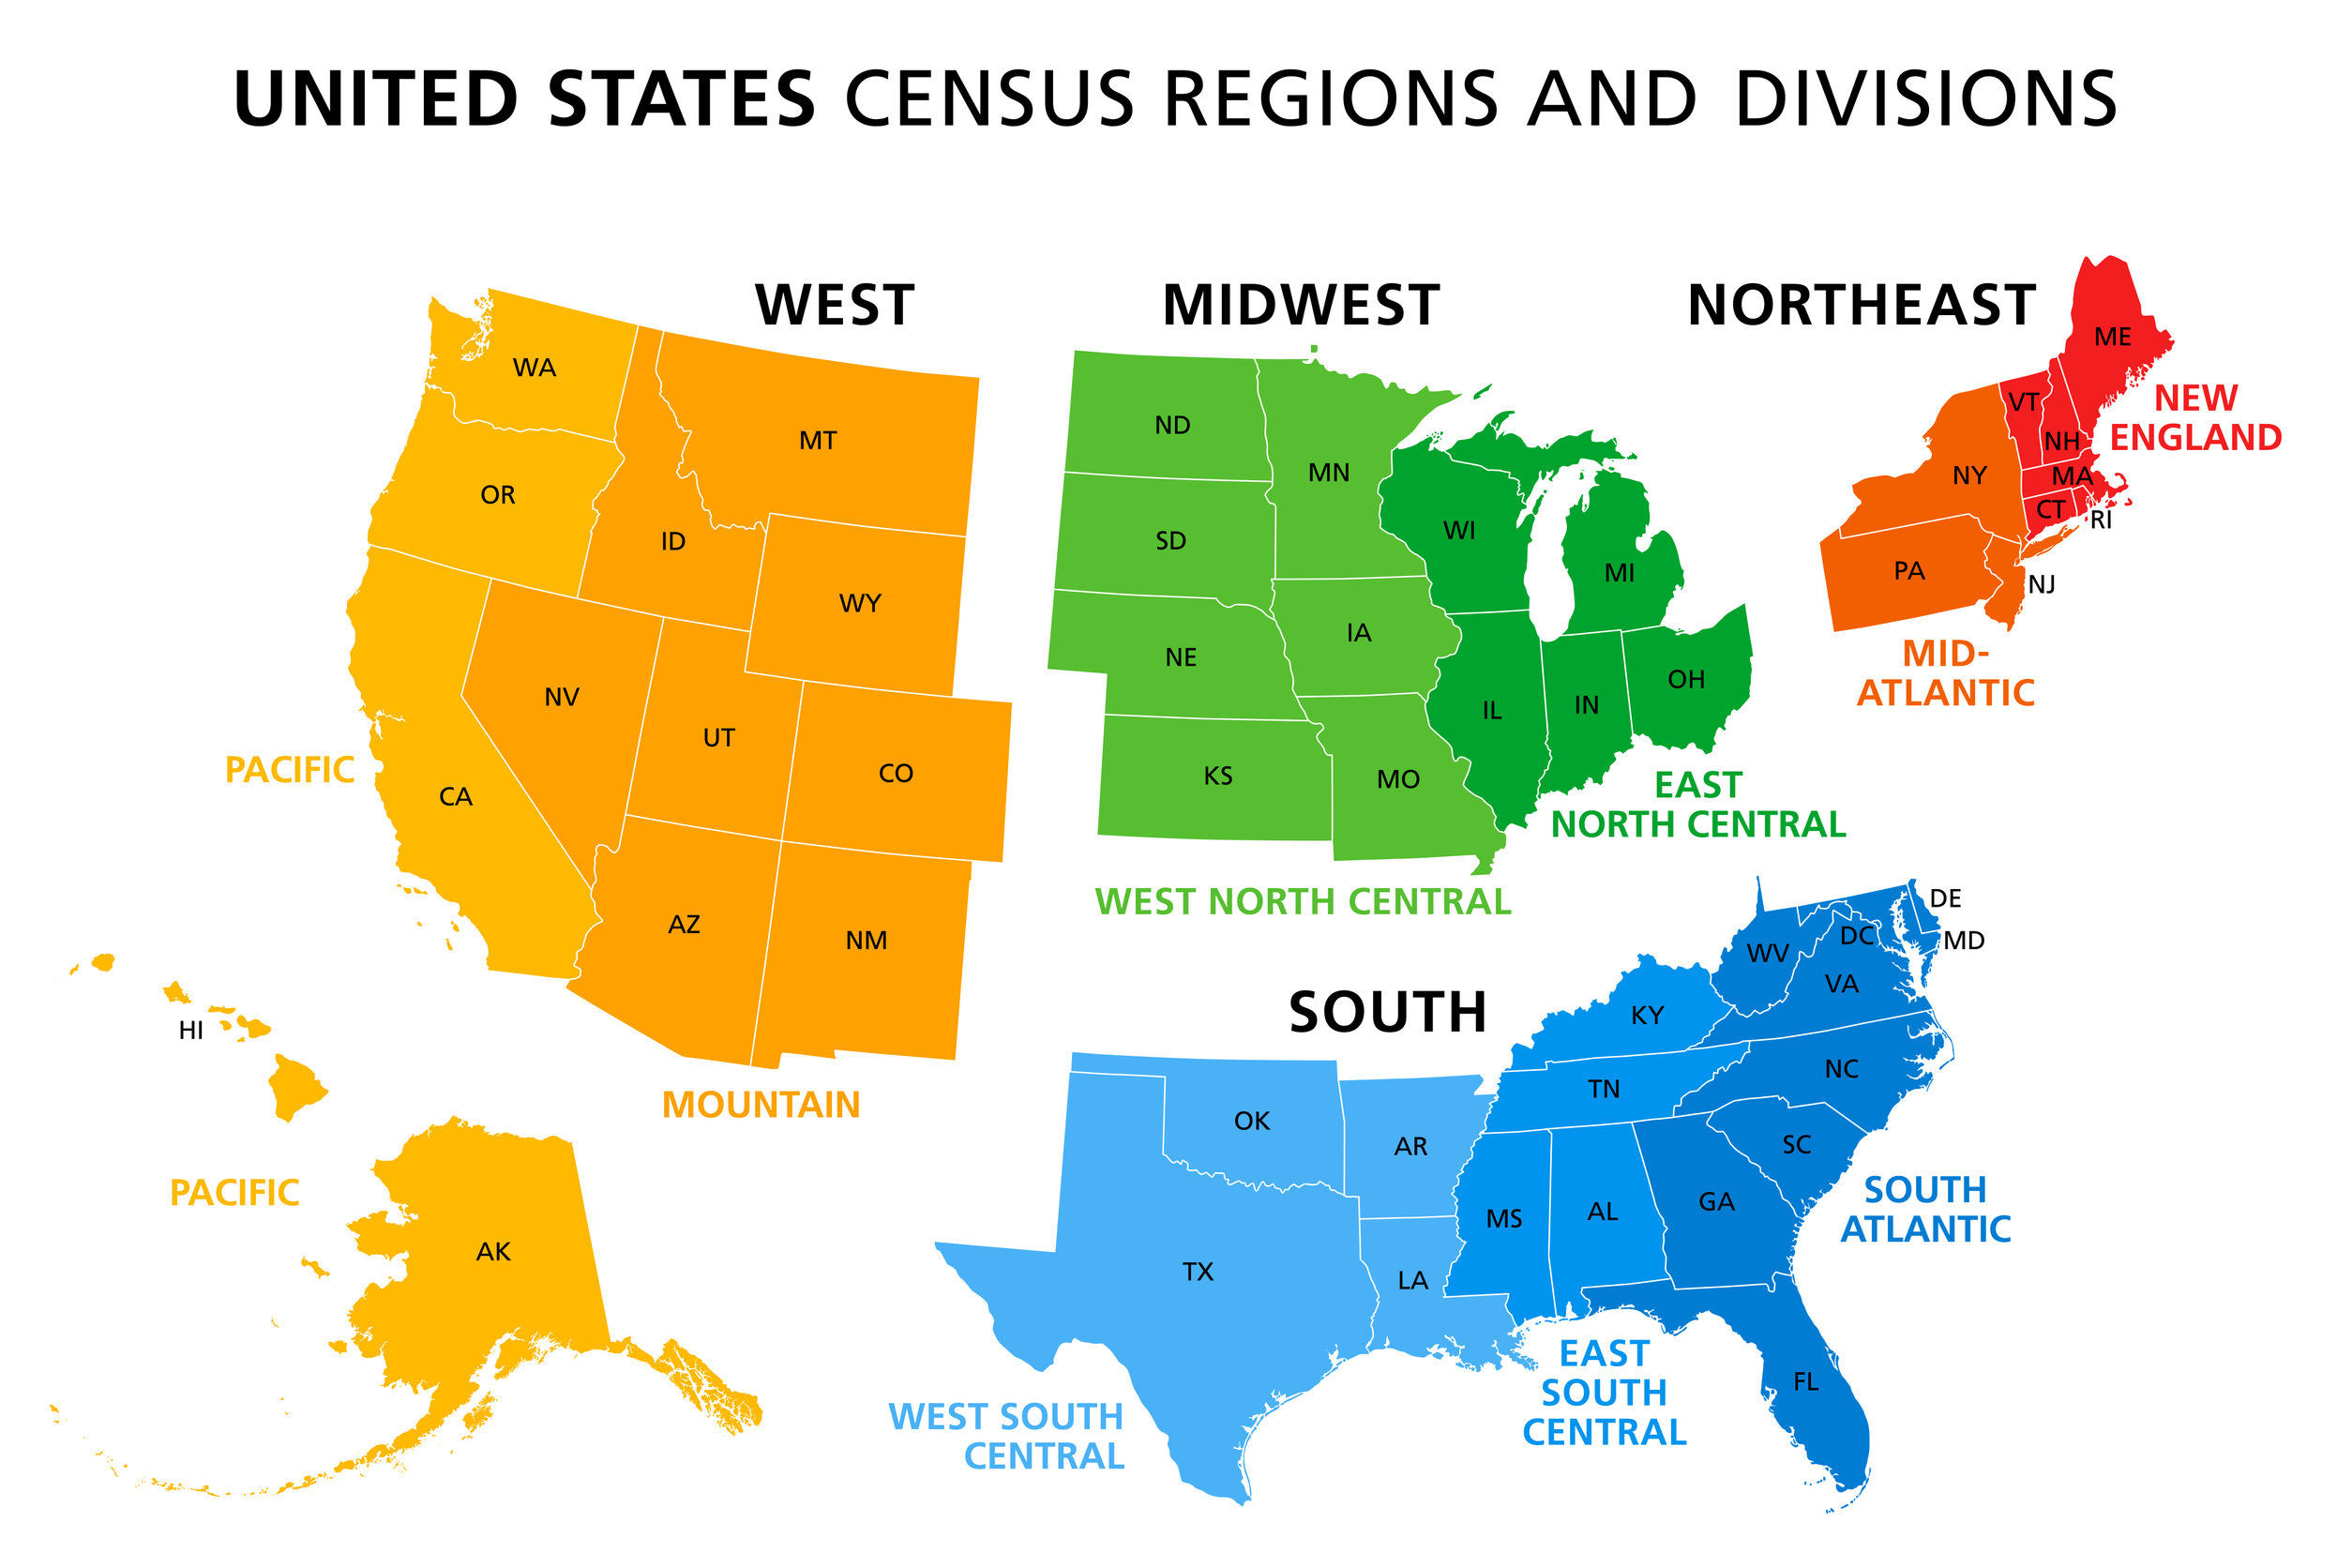


In [15]:
## Create new column called Region
northeast = ['ME','VT','NH','MA','CT','RI','NY','NJ','PA']
midwest = ['OH','MI','IN','IL','WI','MO','IA','MN','ND','SD','NE','KS']
south = ['DE','MD','WV','VA','KY','TN','NC','SC','GA','FL','AL','MS','AR','LA','OK','TX']
west = ['WA','OR','CA','NV','AZ','NM','UT','CO','ID','MT','WY']

# initialize lists of data to used for future violin plots
midwest_data_ME = []
midwest_data_area = []
northeast_data_ME = []
northeast_data_area = []
south_data_ME = []
south_data_area = []
west_data_ME = []
west_data_area = []

Region = []
#iterate through df to sort each row into a region using its state
for i in range(len(df)):
    state = df.iloc[i, 0]
    if state in northeast:
        Region.append('Northeast')
        northeast_data_ME.append(df.iloc[i,13])
        northeast_data_area.append(df.iloc[i,8])
    elif state in midwest:
        Region.append('Midwest')
        midwest_data_ME.append(df.iloc[i,13])
        midwest_data_area.append(df.iloc[i,8])
    elif state in south:
        Region.append('South')
        south_data_ME.append(df.iloc[i,13])
        south_data_area.append(df.iloc[i,8])
    else:
        Region.append('West')
        west_data_ME.append(df.iloc[i,13])
        west_data_area.append(df.iloc[i,8])
# add Region column to dataframe 
df['Region'] = Region

## Step 2: Data Visualizations 

### Bar Graph: Average Number of Household Bedrooms and Bathrooms by Region
One curiosity of mine was to see if there were any differences in the average number of bedrooms and bathrooms contained in homes across regions of the United States. It is a common belief that homes in the midwest and south are typically less expensive for more square footage. Thus,  I wanted to see if this would impact the number of bedrooms and bathrooms.

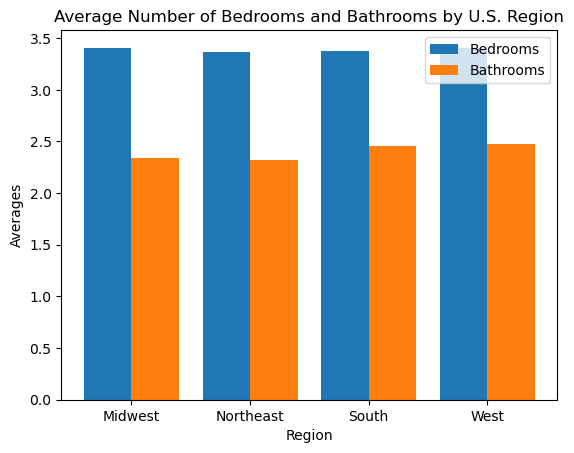

In [16]:
## Bar Graph: region x avg MarketEstimate; # of Bedrooms; # of Bathrooms
MarketEstimate_byRegion = df.groupby("Region")["MarketEstimate"].mean()
Area_byRegion = df.groupby("Region")["Area"].mean()
Bedroom_byRegion= df.groupby("Region")["Bedroom"].mean()
Bathroom_byRegion= df.groupby("Region")["Bathroom"].mean()

# plotting bedroom and bathroom
Region2 = ['Midwest','Northeast','South','West']
X_axis = np.arange(len(Region2)) #Initiate X_axis to manipulate spacing of bars
plt.bar(X_axis-0.2,Bedroom_byRegion,0.4, label='Bedrooms') 
plt.bar(X_axis+0.2,Bathroom_byRegion,0.4, label='Bathrooms')
plt.xticks(X_axis,Region2)
plt.title('Average Number of Bedrooms and Bathrooms by U.S. Region')
plt.ylabel('Averages')
plt.xlabel('Region')
plt.legend()
plt.show()

As you can see from the bar chart, there is so little variation across regions of the United States when it comes to a home's number of bedrooms and bathrooms. Thus, we can conlude that there is not a significant difference across regions.

### Violin Plot (1 of 2): Household Price by Region 

Extending my curiosity of region impacting household features, I am curious to identify whether or not household price appears to be affected by whether a home is in the Midwest, Northeast, South, or West. To explore this, I will be creating a violin plot for each region to compare.

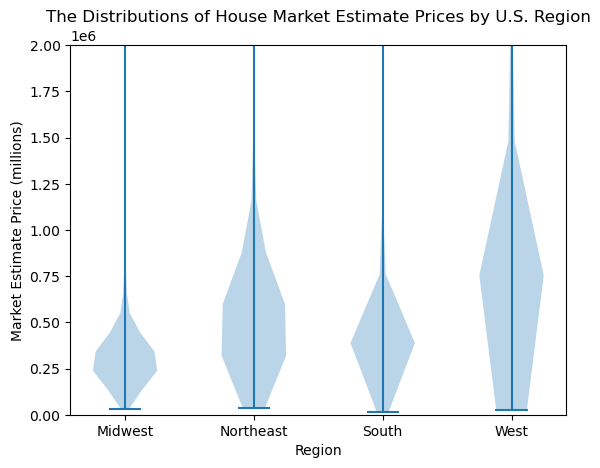

In [17]:
## Violin Plot: region x MarketEstimate; Area

# plotting region vs. Market Estimate 
plt.violinplot([midwest_data_ME,northeast_data_ME,south_data_ME,west_data_ME])

plt.title('The Distributions of House Market Estimate Prices by U.S. Region')
plt.xticks([1,2,3,4],Region2)
plt.ylabel('Market Estimate Price (millions)')
plt.xlabel('Region')
plt.ylim(0,2*10**6) # Set limit so outliers don't obscure plot
plt.show()

**A note: I set a limit for the y-axis because there were extremely large outliers that would have made the graph look like this: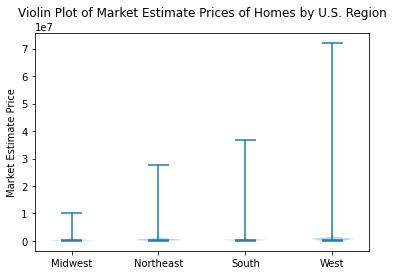 

As to who can afford the 70 million dollar home, props to you. Thus, this is why you did not see the cut off mark for the upper limit of the data. 

Examining the data, we see that there appears to be a wider distribution of house prices in the Northeast and the West. This makes sense as there are many expensive cities located in these regions such as Los Angeles, San francisco, New York City, Boston, etc. 

### Violin Plot (2 of 2): Household Area by Region 
Similar to investigating whether or not Household Price is affected by region, I'm curious to see if the size of the homes is also affected by region. 

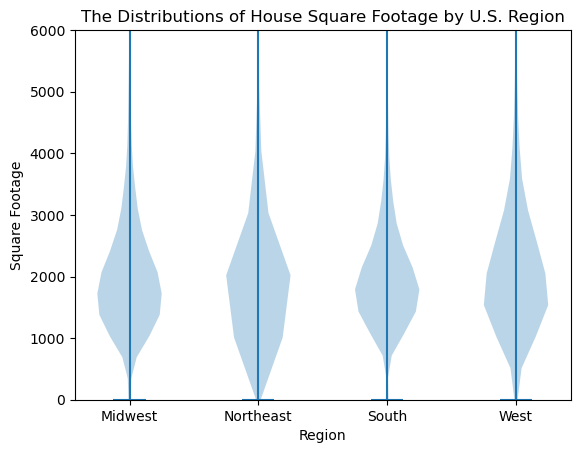

In [18]:
# plotting region vs. Area 
plt.violinplot([midwest_data_area,northeast_data_area,south_data_area,west_data_area])

plt.title('The Distributions of House Square Footage by U.S. Region')
plt.xticks([1,2,3,4],Region2)
plt.ylabel('Square Footage')
plt.xlabel('Region')
plt.ylim(0,6000) # Set limit so outliers don't obscure plot
plt.show()

Looking at the data, it appears that the distributions for houses above 2000 square feet tend to be very similar across all regions. A notable difference however is that in the Northeast and West, there are more homes that are 1000 square feet and below. Thinking about why this is the case, it may be due to the fact that there are more apartment buildings in these areas given the abundance of large cities, thusresulting in a skew toward smaller household areas. 

### Heatmap: Investigating Household Prices via Coordinates
In addition to looking at Household Prices by Region, I wanted to get a more specific visualization that utilizes the Latitude and Longitude data provided in the Kaggle Dataset. Thus, I created a heatmap below that utilizes longitude as the x-axis, latitude as the y-axis, and the magnitude of Household Price as the color of the cells. 

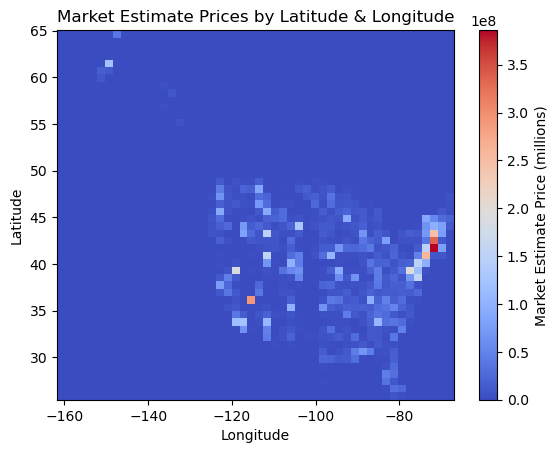

In [19]:
## Heatmap: MarketEstimate Prices x Coordinates (latitude & longitude)
Z, hmx, hmy = np.histogram2d(df['Longitude'],df['Latitude'], bins=50,weights=df['MarketEstimate'])
plt.title('Market Estimate Prices by Latitude & Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
heatmap = plt.pcolormesh(hmx,hmy,Z.T, cmap='coolwarm',shading='auto')
colorbar = plt.colorbar(heatmap) #add a colorbar legend
colorbar.set_label('Market Estimate Price (millions)')
plt.show()

At a first glance, the graph may look a little odd, as there seems to be one blob with a couple dots in the top left corner. If you look a little closer, the large blob outlines the United States and the few dots lingering at the top belong to homes in Alaska. Examining the graph, we see that there is a relatively even spread of light blue and dark blue throughout the whole country, with few high cost residences in New York City and what appears to be Las Vegas. 

## Step 3: Modeling

### Linear Regression Model (1 of 2): Predicting Household Price with Area, num of Bedrooms, and num of Bathrooms
To answer our primary inquiry, we want to see whether or not it is possible to produce a good prediction of household price given the features in the dataset. Thus, the ones I thought could yield high predicting power was the square footage of the house, the number of bedrooms, as well as the number of bathrooms, since these are common characteristics that drive up a house's price.

In [22]:
## Regression Model: Area,bedrooms,bathrooms predicting MarketEstimate
feature = df[['Area','Bedroom','Bathroom']]
target = df['MarketEstimate']
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)
model = LinearRegression() #execute model
model.fit(x_train, y_train) #fit training data to model
model_predictions = model.predict(x_test)

# coefficients & intercept
coefs = model.coef_
intercept = model.intercept_
print(f'These are the weights and intercept of the model equation: {coefs} , {intercept}')

# calculate root mean squared error as accuracy metric
model_MSE = root_mean_squared_error(y_test,model_predictions)**2
print(f'This is the Model Mean Squared Error: {model_MSE}')

These are the weights and intercept of the model equation: [   186.98230927 -70984.46375868 119545.77795158] , 33513.04489495768
This is the Model Mean Squared Error: 747330129877.9817


Model Equation: Household Price = 186.9823 x Area(sq ft) - 70984 x Number of Bedrooms + 119545 x Number of Bathrooms + 33513.045

#### Calculating Accuracy of the Model:

In [24]:
# calculate root mean squared error as accuracy metric
model_MSE = root_mean_squared_error(y_test,model_predictions)**2
print(f'This is the Model Mean Squared Error: {model_MSE}')

This is the Model Mean Squared Error: 747330129877.9817


Whoa! As you can see, the model's mean squared error is tremendously large, reaching over 700 billion. This indicates that the current model does a very poor job predicting housing price when using area, num of bedrooms, and num of bathrooms as features. 

### Linear Regression Model (2 of 2): Predicting Household Price with Area ONLY
Reflecting on what could have led toward the unexpectedly large MSE value, perhaps we should remove the features of bed and bathroom. This is because these features are relatively discrete; yes you could have half a bath, but the other decimals in between integers are non-existent. Thus, using a non-continuous variable in a linear regression model is detrimental in predicting a continuous variable like housing price. So, I repeated the same model above, but only using household area as the feature.

In [28]:
## Regression Model: Area predicting MarketEstimate
feature = df[['Area']]
target = df['MarketEstimate']
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)
model = LinearRegression() #execute model
model.fit(x_train, y_train) #fit training data to model
model_predictions = model.predict(x_test)

# coefficients & intercept
coefs = model.coef_
intercept = model.intercept_
print(f'These are the weights and intercept of the model equation: {coefs} , {intercept}')

These are the weights and intercept of the model equation: [225.04910952] , 952.1027531821746


Model Equation: Household Price = 225.0049 x Area(sq ft) + 952.103

In [ ]:
### Calculating Accuracy of the Revised Model

In [49]:
# calculate root mean squared error as accuracy metric
model_MSE = root_mean_squared_error(y_test,model_predictions)**2
print(f'This is the Model Mean Squared Error: {model_MSE}')

This is the Model Mean Squared Error: 768121925026.4517


Wow... Instead of increasing in accuracy, it appears the mean squared error actually increased! This indicates how difficult it is to predict housing price based on one feature like area. In the future, if I were to repeat this inquiry again, I think a factor I would definitely consider is location and the housing prices of neighboring homes. Since many house prices are largely based on the price of other houses in the neighborhood, I could use a 2D plane to plot the coordinates of all the homes in a dataset and implement an algorithm that selects the mean of the 10 closest homes to use as a feature for my model!

## KMeans Clustering Model: Classifying Homes into 'Affordable', 'Family', 'Luxury'
To bounce back from those insane MSE values, I decided to finish off with a different type of model; one that clusters and classfies data as opposed to doing flat out predictions. Purely based off of curiosity, I thought it would be neat if one could characterize each of the homes in a dataset to three categories that could help consumers with their house hunting. The three categories are: 

Affordable: smaller homes; intended for individuals or couples that want a smaller space with an affordable price.
Family: medium-sized homes; intended for familes that require a larger space and have a wider budget to work with.
Luxury: large-sized homes; intended for those who have a considerably large budget and want something above and beyond the conventional. 

In [55]:
## KMeans classifier model: classifying homes into Affordable, family, luxury
features2 = df[['MarketEstimate','Area','Bedroom','Bathroom']]
scaler = StandardScaler() #standardize data
features_scaled = scaler.fit_transform(features2)

kmeans = KMeans(n_clusters=3,random_state=42) # 3 clusters for affordable,family,luxury
df['Classification'] = kmeans.fit_predict(features_scaled)

# Define the mapping for cluster labels
cluster_mapping = {0: 'Affordable', 1: 'Family', 2: 'Luxury'}

# Apply the mapping to the 'Classification' column
df['Classification'] = df['Classification'].map(cluster_mapping)

In [56]:
## Display addresses with classifier
print(df[['Street', 'Classification']])

                  Street Classification
0               Scott Dr         Family
1           Big Oak Dr W         Family
2        Cowpen Creek Rd         Family
3      Spinnaker Dr #201         Family
4             Mallet Way         Family
...                  ...            ...
24130          Road 210a         Family
24131        Lincoln Ave         Family
24132           Mason Dr         Family
24133        Carolina Rd         Family
24134             6th St         Family

[24135 rows x 2 columns]
